In [1]:
# Importing core libraries
import seaborn as sns
import scipy.stats as ss
import math 
import numpy as np
import pandas as pd
import pprint
import joblib

from collections import Counter
from time import time
from matplotlib import pyplot as plt
from scipy import stats
# Classifiers
from catboost import CatBoostClassifier, Pool

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer

## Reading the Data and Preprocessing

In [2]:
df_train = pd.read_csv('../input/bri-data-hackathon-pa/train.csv')
df_test = pd.read_csv('../input/bri-data-hackathon-pa/test.csv')
sample_submission = pd.read_csv('../input/bri-data-hackathon-pa/sample_submission.csv')

#df_train = df_train.drop(['age','year_graduated'],axis=1)
#df_test = df_test.drop(['age','year_graduated'],axis=1)

In [3]:
numbers = df_train.age
age_numbers = [2020 - number for number in numbers]
df_train.age = age_numbers

num = df_test.age
age_num = [2020 - x for x in num]
df_test.age = age_num

In [4]:
numbers1 = df_train.year_graduated
age_numbers1 = [2020 - number for number in numbers1]
df_train.year_graduated = age_numbers1

num1 = df_test.year_graduated
age_num1 = [2020 - x for x in num1]
df_test.year_graduated = age_num1

In [5]:
#change GPA 4.1-41 Train
column_name = 'GPA'

mask1 = (df_train.GPA >= 4.1) & (df_train.GPA <= 41)
df_train.loc[mask1, column_name] = df_train.GPA / 10

#change GPA 41-410 Train

mask2 = (df_train.GPA >= 41) & (df_train.GPA <= 410)
df_train.loc[mask2, column_name] = df_train.GPA / 100

#change GPA 4.1-41 Test

mask3 = (df_test.GPA >= 4.1) & (df_test.GPA <= 41)
df_test.loc[mask3, column_name] = df_test.GPA / 10

#change GPA 41-410 Test

mask4 = (df_test.GPA >= 41) & (df_test.GPA <= 410)
df_test.loc[mask4, column_name] = df_test.GPA / 100

In [6]:
#df_train['Last_achievement_%'] = df_train['Last_achievement_%'] / 100
#df_test['Last_achievement_%'] = df_test['Last_achievement_%'] / 100

In [7]:
df_train['quantile_current_branch'] = pd.qcut(df_train['job_duration_in_current_branch'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=False,
                            duplicates='drop')
df_test['quantile_current_branch'] = pd.qcut(df_test['job_duration_in_current_branch'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=False,
                            duplicates='drop')

In [8]:
jblv1 = 'job_level'

filt = df_train[jblv1] == 'JG03'
df_train.loc[filt, jblv1] = 0

filt2 = (df_train[jblv1] == 'JG04')
df_train.loc[filt2, jblv1] = 1

filt3 = (df_train[jblv1] == 'JG05')
df_train.loc[filt3, jblv1] = 2

#test

j11 = 'job_level'

filt1 = df_test[j11] == 'JG03'
df_test.loc[filt1, j11] = 0

filt22 = (df_test[j11] == 'JG04')
df_test.loc[filt22, j11] = 1

filt33 = (df_test[j11] == 'JG05')
df_test.loc[filt33, j11] = 2

filt44 = (df_test[j11] == 'JG06')
df_test.loc[filt44, j11] = 2

In [9]:
perlv1 = 'person_level'

filt = df_train[perlv1] == 'PG01'
df_train.loc[filt, perlv1] = 0
filt2 = (df_train[perlv1] == 'PG02')
df_train.loc[filt2, perlv1] = 1
filt3 = (df_train[perlv1] == 'PG03')
df_train.loc[filt3, perlv1] = 2
filt4 = (df_train[perlv1] == 'PG04')
df_train.loc[filt4, perlv1] = 3
filt5 = (df_train[perlv1] == 'PG05')
df_train.loc[filt5, perlv1] = 4
filt6 = (df_train[perlv1] == 'PG06')
df_train.loc[filt6, perlv1] = 5
filt7 = (df_train[perlv1] == 'PG07')
df_train.loc[filt7, perlv1] = 6
filt8 = (df_train[perlv1] == 'PG08')
df_train.loc[filt8, perlv1] = 7

#test
filt = df_test[perlv1] == 'PG01'
df_test.loc[filt, perlv1] = 0
filt2 = (df_test[perlv1] == 'PG02')
df_test.loc[filt2, perlv1] = 1
filt3 = (df_test[perlv1] == 'PG03')
df_test.loc[filt3, perlv1] = 2
filt4 = (df_test[perlv1] == 'PG04')
df_test.loc[filt4, perlv1] = 3
filt5 = (df_test[perlv1] == 'PG05')
df_test.loc[filt5, perlv1] = 4
filt6 = (df_test[perlv1] == 'PG06')
df_test.loc[filt6, perlv1] = 5
filt7 = (df_test[perlv1] == 'PG07')
df_test.loc[filt7, perlv1] = 6
filt8 = (df_test[perlv1] == 'PG08')
df_test.loc[filt8, perlv1] = 7

In [10]:
emptype1 = 'Employee_type'

filt = df_train[emptype1] == 'RM_type_C'
df_train.loc[filt, emptype1] = 0

filt2 = (df_train[emptype1] == 'RM_type_B')
df_train.loc[filt2, emptype1] = 1

filt3 = (df_train[emptype1] == 'RM_type_A')
df_train.loc[filt3, emptype1] = 2

#test
filt = df_test[emptype1] == 'RM_type_C'
df_test.loc[filt, emptype1] = 0

filt2 = (df_test[emptype1] == 'RM_type_B')
df_test.loc[filt2, emptype1] = 1

filt3 = (df_test[emptype1] == 'RM_type_A')
df_test.loc[filt3, emptype1] = 2

In [11]:
edulvl1 = 'Education_level'

filt = df_train[edulvl1] == 'level_0'
df_train.loc[filt, edulvl1] = 0

filt2 = (df_train[edulvl1] == 'level_1')
df_train.loc[filt2, edulvl1] = 1

filt3 = (df_train[edulvl1] == 'level_2')
df_train.loc[filt3, edulvl1] = 2

filt4 = (df_train[edulvl1] == 'level_3')
df_train.loc[filt4, edulvl1] = 3

filt5 = (df_train[edulvl1] == 'level_4')
df_train.loc[filt5, edulvl1] = 4

filt6 = (df_train[edulvl1] == 'level_5')
df_train.loc[filt6, edulvl1] = 5

#test
filt = df_test[edulvl1] == 'level_0'
df_test.loc[filt, edulvl1] = 0

filt2 = (df_test[edulvl1] == 'level_1')
df_test.loc[filt2, edulvl1] = 1

filt3 = (df_test[edulvl1] == 'level_2')
df_test.loc[filt3, edulvl1] = 2

filt4 = (df_test[edulvl1] == 'level_3')
df_test.loc[filt4, edulvl1] = 3

filt5 = (df_test[edulvl1] == 'level_4')
df_test.loc[filt5, edulvl1] = 4

filt6 = (df_test[edulvl1] == 'level_5')
df_test.loc[filt6, edulvl1] = 5

# outlier

In [12]:
for c in df_train.columns: display(df_train[c].value_counts().to_frame())

,job_level
1,10413
2,704
0,36


,job_duration_in_current_job_level
1.352775,1517
1.385641,1424
1.224745,902
1.322876,841
1.256981,736
...,...
2.019901,1
2.102380,1
2.061553,1
2.915476,1


,person_level
2,9655
3,757
5,378
4,308
0,19
6,19
1,16
7,1


,job_duration_in_current_person_level
1.352775,1511
1.385641,1425
1.224745,953
1.322876,841
1.256981,736
...,...
1.780449,1
2.019901,1
2.814249,1
2.381176,1


,job_duration_in_current_branch
0.707107,3630
1.224745,2341
1.581139,899
0.648074,429
1.555635,406
...,...
2.218107,1
2.381176,1
2.291288,1
2.677686,1


,Employee_type
2,7287
1,3380
0,486


,gender
2,8204
1,2949


,age
32,1558
33,1473
34,1348
31,1323
35,954
30,926
36,654
29,511
37,472
38,286


,marital_status_maried(Y/N)
Y,9501
N,1652


,number_of_dependences
1,4185
0,3779
2,2674
3,497
4,13
5,4
7,1


,Education_level
4,9222
3,1743
1,140
5,43
2,4
0,1


,GPA
0.0000,2148
3.0000,382
3.0100,230
3.1000,199
3.0300,187
...,...
2.2500,1
0.4735,1
2.5200,1
2.5600,1


,year_graduated
9,1693
10,1531
8,1339
11,1204
12,1069
7,875
13,670
6,616
14,421
15,295


,job_duration_from_training
6,2611
5,2226
3,2037
4,1742
7,670
2,529
15,190
16,163
14,157
13,135


,branch_rotation
3,3404
2,3271
4,1809
5,729
1,417
6,311
7,228
9,220
8,217
10,198


,job_rotation
2,3656
3,3621
4,1858
5,690
6,349
7,317
8,295
9,201
10,88
11,34


,assign_of_otherposition
0,7303
1,1385
2,684
3,476
4,309
5,250
6,190
7,145
8,102
9,82


,annual leave
3,2698
2,1497
0,1447
5,1333
4,1154
6,847
1,705
7,479
8,405
9,240


,sick_leaves
0,7196
1,1496
2,958
3,499
4,286
5,193
6,139
7,99
8,64
10,42


,Last_achievement_%
13.00,52
117.00,11
62.56,8
52.00,8
55.21,8
...,...
104.40,1
86.30,1
93.84,1
14.73,1


,Achievement_above_100%_during3quartal
0.0,7597
3.0,1604
1.0,1141
2.0,810


,Best Performance
0,9516
1,1637


,quantile_current_branch
0,4928
1,3590
3,2209
2,426


based on this we should detect outliers from [GPA,	
Last_achievement_%, job_duration_in_current_branch,
job_duration_in_current_person_level,
job_duration_in_current_job_level]

**GPA**

In [13]:
#Inter Quartile Range(IQR)
outlier = []
def iqr_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            outlier.append(i)
    print("Outliers:",outlier)
iqr_outliers(df_train['GPA'])

Outliers: [0.728, 0.0, 0.0, 0.72, 0.0, 0.0, 0.0, 0.41900000000000004, 0.0, 0.8300000000000001, 0.0, 0.0, 0.682, 0.782, 0.7, 0.0, 0.0, 0.0, 0.869, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45, 0.45289999999999997, 0.4483, 0.0, 0.8099999999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4357, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.618, 0.0, 0.0, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5306000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.0, 0.0, 0.749, 1.34, 0.0, 0.636, 0.0, 0.4303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8400000000000001, 0.0, 0.0, 1.55, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47350000000000003, 0.0, 0.4456, 0.0, 0.66, 0.0, 0.0, 0.0, 1.343, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [14]:
def replace(GPA):
    if GPA in outlier:
        return np.nan
    else:
        return GPA
df_train.GPA = df_train.GPA.apply(replace)
df_test.GPA = df_test.GPA.apply(replace)

**last**

In [15]:
last_outlier = []
def last_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            last_outlier.append(i)
    print("Outliers:",last_outlier)
last_outliers(df_train['Last_achievement_%'])

Outliers: [4.69, 4.51, 4.52]


In [16]:
def last_replace(Last):
    if Last in last_outlier:
        return np.nan
    else:
        return Last
df_train['Last_achievement_%'] = df_train['Last_achievement_%'].apply(last_replace)
df_test['Last_achievement_%'] = df_test['Last_achievement_%'].apply(last_replace)

**branch**

In [17]:
branch_outlier = []
def branch_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            branch_outlier.append(i)
    print("Outliers:",branch_outlier)
branch_outliers(df_train['job_duration_in_current_branch'])

Outliers: [2.10237960416286, 2.12132034355964, 2.12132034355964, 2.10237960416286, 2.19772609758359, 2.12132034355964, 2.2737634001804103, 2.12132034355964, 2.12132034355964, 2.0615528128088303, 2.41453929352993, 2.01990098767242, 2.01990098767242, 2.12132034355964, 2.23606797749979, 2.0615528128088303, 2.10237960416286, 2.0615528128088303, 2.12132034355964, 2.12132034355964, 2.12132034355964, 2.10237960416286, 2.34520787991171, 2.12132034355964, 2.12132034355964, 2.3811761799581297, 2.25388553391693, 2.10237960416286, 2.12132034355964, 2.12132034355964, 2.25388553391693, 2.04205778566621, 2.10237960416286, 2.14009345590327, 2.10237960416286, 2.10237960416286, 2.12132034355964, 2.2737634001804103, 2.12132034355964, 2.10237960416286, 2.67768556779918, 2.12132034355964, 2.19772609758359, 2.23606797749979, 2.34520787991171, 2.01990098767242, 2.30867927612304, 2.3280893453645604, 2.3280893453645604, 2.12132034355964, 2.04205778566621, 2.17944947177034, 2.25388553391693, 2.08086520466848, 2

In [18]:
def branch_replace(branch):
    if branch in branch_outlier:
        return np.nan
    else:
        return branch
df_train['job_duration_in_current_branch'] = df_train['job_duration_in_current_branch'].apply(branch_replace)
df_test['job_duration_in_current_branch'] = df_test['job_duration_in_current_branch'].apply(branch_replace)

**job**

In [19]:
joblevel_outlier = []
def joblevel_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            joblevel_outlier.append(i)
    print("Outliers:",joblevel_outlier)
joblevel_outliers(df_train['job_duration_in_current_job_level'])

Outliers: [2.5651510676761298, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.73861278752583, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.39791576165636, 2.73861278752583, 2.6925824035672496, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.73861278752583, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 1.9364916731037096, 2.66082693913001, 2.82842712474619, 2.82842712474619, 2.6925824035672496, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.82842712474619, 2.23606797749979, 2.8425340807103803, 2.56515

In [20]:
def joblevel_replace(joblevel):
    if joblevel in joblevel_outlier:
        return np.nan
    else:
        return joblevel
df_train['job_duration_in_current_job_level'] = df_train['job_duration_in_current_job_level'].apply(joblevel_replace)
df_test['job_duration_in_current_job_level'] = df_test['job_duration_in_current_job_level'].apply(joblevel_replace)

**person**

In [21]:
personlevel_outlier = []
def personlevel_outliers(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for i in df:
        if i > Upper_tail or i < Lower_tail:
            personlevel_outlier.append(i)
    print("Outliers:",personlevel_outlier)
personlevel_outliers(df_train['job_duration_in_current_job_level'])

Outliers: [1.6340134638368202, 1.6822603841260702, 1.6340134638368202, 1.6583123951777, 1.6340134638368202, 1.6583123951777, 1.6583123951777, 1.6822603841260702, 1.6340134638368202, 1.6822603841260702, 1.6340134638368202, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6822603841260702, 1.6822603841260702, 1.6583123951777, 1.6583123951777, 1.6340134638368202, 1.6340134638368202, 1.6583123951777, 1.6340134638368202, 0.9591663046625442, 1.6340134638368202, 1.6340134638368202, 1.6340134638368202, 1.6583123951777, 1.6340134638368202, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6340134638368202, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6583123951777, 1.6340134638368202, 1.6822603841260702, 1.6340134638368202, 1.6583123951777, 1.6340134638368202, 1.6340134638368202,

In [22]:
def personlevel_replace(personlevel):
    if personlevel in personlevel_outlier:
        return np.nan
    else:
        return personlevel
df_train['job_duration_in_current_job_level'] = df_train['job_duration_in_current_job_level'].apply(personlevel_replace)
df_test['job_duration_in_current_job_level'] = df_test['job_duration_in_current_job_level'].apply(personlevel_replace)

In [23]:
#df_features
binary_var = ['gender','marital_status_maried(Y/N)']
nominal = ['age','year_graduated',
           'job_duration_in_current_job_level',
           'job_duration_in_current_person_level',
           'job_duration_in_current_branch',           
           'GPA',
           'job_duration_from_training',
           'branch_rotation',
           'job_rotation',
           'assign_of_otherposition',
           'annual leave',
           'sick_leaves',
           'Last_achievement_%',
           'Achievement_above_100%_during3quartal',]
ordinal = ['job_level',
           'person_level',
           'Employee_type',
           'number_of_dependences',
           'Education_level',
          ]
cols = binary_var + nominal + ordinal

In [24]:
y = df_train['Best Performance'].values
X = df_train.drop(['Best Performance'],axis=1)
Xt = df_test

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11153 entries, 0 to 11152
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   job_level                              11153 non-null  object 
 1   job_duration_in_current_job_level      9333 non-null   float64
 2   person_level                           11153 non-null  object 
 3   job_duration_in_current_person_level   11153 non-null  float64
 4   job_duration_in_current_branch         11077 non-null  float64
 5   Employee_type                          11153 non-null  object 
 6   gender                                 11153 non-null  int64  
 7   age                                    11153 non-null  int64  
 8   marital_status_maried(Y/N)             11153 non-null  object 
 9   number_of_dependences                  11153 non-null  int64  
 10  Education_level                        11153 non-null  object 
 11  GP

# **Scaling**

In [26]:
from sklearn.preprocessing import MinMaxScaler

# Min-max normalization
X[ordinal] = MinMaxScaler().fit_transform(X[ordinal])
Xt[ordinal] = MinMaxScaler().fit_transform(Xt[ordinal])

In [27]:
# Transforming all the labels of all variables
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in range(X.shape[1])]

for col, column in enumerate(X.columns):
    unique_values = pd.Series(X[column].append(Xt[column]).unique())
    unique_values = unique_values[unique_values.notnull()]
    label_encoders[col].fit(unique_values)
    X.loc[X[column].notnull(), column] = label_encoders[col].transform(X.loc[X[column].notnull(), column])
    Xt.loc[Xt[column].notnull(), column] = label_encoders[col].transform(Xt.loc[Xt[column].notnull(), column])

In [28]:
#X = X.fillna(-999)
#Xt = Xt.fillna(-999)

X = X.apply(lambda x: x.fillna(x.mean()),axis=0)
Xt = Xt.apply(lambda x: x.fillna(x.mean()),axis=0)

In [29]:
def frequency_encoding(column, df, df_test=None):
    frequencies = df[column].value_counts().reset_index()
    df_values = df[[column]].merge(frequencies, how='left', 
                                   left_on=column, right_on='index').iloc[:,-1].values
    if df_test is not None:
        df_test_values = df_test[[column]].merge(frequencies, how='left', 
                                                 left_on=column, right_on='index').fillna(1).iloc[:,-1].values
    else:
        df_test_values = None
    return df_values, df_test_values

for column in X.columns:
    train_values, test_values = frequency_encoding(column, X, Xt)
    X[column+'_freq'] = train_values
    Xt[column+'_freq'] = test_values

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1155: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [30]:
import category_encoders as cat_encode


enc_x = np.zeros(X[cols].shape)

for tr_idx, oof_idx in StratifiedKFold(n_splits=5, random_state=2021, shuffle=True).split(X, y):
    encoder = cat_encode.TargetEncoder(cols=cols, smoothing=0.3)
    
    encoder.fit(X[cols].iloc[tr_idx], y[tr_idx])
    enc_x[oof_idx, :] = encoder.transform(X[cols].iloc[oof_idx], y[oof_idx])
    
encoder.fit(X[cols], y)
enc_xt = encoder.transform(Xt[cols]).values

for idx, new_var in enumerate(cols):
    new_var = new_var + '_enc'
    X[new_var] = enc_x[:,idx]
    Xt[new_var] = enc_xt[:, idx]

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: Future

In [31]:
feature_name = list(X.columns)
# no of maximum features we need to select
num_feats=50

# 1. Pearson correlation

In [32]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X, y,num_feats)
print(str(len(cor_feature)), 'selected features')

50 selected features


cor_feature

# 2. Chi-Square Features

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

50 selected features


chi_feature

# 3. Recursive Feature Elimination

In [34]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 65 features.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 55 features.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


RFE(estimator=LogisticRegression(), n_features_to_select=50, step=10, verbose=5)

In [35]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

50 selected features


rfe_feature

# 4. Lasso: SelectFromModel

In [36]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


SelectFromModel(estimator=LogisticRegression(), max_features=50)

In [37]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

27 selected features


embeded_lr_feature

# 5. Tree-based: SelectFromModel

In [38]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(), max_features=50)

In [39]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

31 selected features


embeded_rf_feature

In [40]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

model= LGBMClassifier(random_state=33,
                      #early_stopping_rounds = 250,
                      n_estimators=2000,min_data_per_group=5, # reduce overfitting when using categorical_features
                      boosting_type='gbdt', num_leaves=170, max_depth=- 1, learning_rate=0.01, subsample_for_bin=2000, 
                      min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, 
                      colsample_bytree=.75, reg_alpha=1.3, reg_lambda=0.1,  n_jobs=- 1,cat_smooth=1.0, 
                      silent=True, importance_type='split')

embeded_lgb_selector = SelectFromModel(model, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(cat_smooth=1.0, colsample_bytree=0.75,
                                         learning_rate=0.01,
                                         min_data_per_group=5,
                                         n_estimators=2000, num_leaves=170,
                                         random_state=33, reg_alpha=1.3,
                                         reg_lambda=0.1,
                                         subsample_for_bin=2000),
                max_features=50)

In [41]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

28 selected features


embeded_lgb_feature

In [42]:
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

xgb_model= xgb.XGBClassifier(n_estimators=2000,
                         max_depth=12, 
                         learning_rate=0.02, 
                         subsample=0.8,
                         colsample_bytree=0.4, 
                         missing=-1,)

embeded_xgb_selector = SelectFromModel(xgb_model, max_features=num_feats)
embeded_xgb_selector.fit(X, y)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:46:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=0.4, gamma=None,
                                        gpu_id=None, importance_type='gain',
                                        interaction_constraints=None,
                                        learning_rate=0.02, max_delta_step=None,
                                        max_depth=12, min_child_weight=None,
                                        missing=-1, monotone_constraints=None,
                                        n_estimators=2000, n_jobs=None,
                                        num_parallel_tree=None,
                                        random_state=None, reg_alpha=None,
                                        reg_lambda=None, scale_pos_weight=None,
                                        subsample=0.8

In [43]:
embeded_xgb_support = embeded_lgb_selector.get_support()
embeded_xgb_feature = X.loc[:,embeded_xgb_support].columns.tolist()
print(str(len(embeded_xgb_feature)), 'selected features')

28 selected features


# Features

In [44]:

#pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 
                                     'Pearson':cor_support, 
                                     'Chi-2':chi_support, 
                                     'RFE':rfe_support, 
                                     'Logistics':embeded_lr_support,
                                     'Random Forest':embeded_rf_support, 
                                     'LightGBM':embeded_lgb_support,
                                     'XGBoost' :embeded_xgb_support
                                    })
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,XGBoost,Total
1,job_duration_in_current_job_level,True,True,True,True,True,True,True,7
2,job_duration_in_current_branch_enc,True,True,True,True,True,True,True,7
3,job_duration_in_current_branch,True,True,True,True,True,True,True,7
4,job_duration_from_training_enc,True,True,True,True,True,True,True,7
5,branch_rotation_enc,True,True,True,True,True,True,True,7
...,...,...,...,...,...,...,...,...,...
61,Education_level_enc,True,False,True,False,False,False,False,2
62,person_level,False,False,True,False,False,False,False,1
63,job_duration_in_current_job_level_freq,False,False,False,False,True,False,False,1
64,number_of_dependences_freq,False,False,False,False,False,False,False,0


In [45]:
feature_selected = feature_selection_df.loc[(feature_selection_df.Total >= 3)]
features = feature_selected.Feature.tolist()

In [46]:
X = X.astype(np.float32)
Xt = Xt.astype(np.float32)

# Defining categorical variables
cat_features = features
#cat_features = cols
# Setting categorical variables to int64
X[cat_features] = X[cat_features].astype(np.int64)
Xt[cat_features] = Xt[cat_features].astype(np.int64)

In [47]:
#from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state = 42)
#X, y = smote.fit_resample(X,y)


#sns.countplot(y)

In [48]:
import gc
_ = gc.collect()

# **MODELING**

In [49]:
# Initializing a CatBoostClassifier with best parameters
"""
param_cb = {'bagging_temperature': 0.8,
               'depth': 5,
               'iterations': 1000,
               'l2_leaf_reg': 30,
               'learning_rate': 0.05,
               'random_strength': 0.8,
            'bootstrap_type' : 'Bayesian',
            'objective':'CrossEntropy',
           }
"""

param_cb = {
        'learning_rate': 0.05,
        'random_strength': 0.8,
        'bagging_temperature': 0.8, 
        'l2_leaf_reg': 30,
        'depth': 12, 
        #'max_leaves': 48,
        'max_bin':255,
        'iterations' : 1000,
        #'task_type':'GPU',
        'loss_function' : "Logloss",
        'objective':'CrossEntropy',
        'eval_metric' : "AUC",
        'bootstrap_type' : 'Bayesian',
        'use_best_model': True 
}


In [50]:
# Setting a n-fold stratified cross-validation (note: shuffle=True)
SEED = 2021
#SEED = 42
FOLDS = 100
#FOLDS = 5
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

In [51]:
# CV interations
roc_auc = list()
average_precision = list()
oof = np.zeros(len(X))
cv_test_preds = np.zeros(len(Xt))
best_iteration = list()
#i = 1
for train_idx, test_idx in skf.split(X, y):
    #print("\nfold {}".format(i))
    X_train, y_train = X.iloc[train_idx, :], y[train_idx]
    X_test, y_test = X.iloc[test_idx, :], y[test_idx]
    
    train = Pool(data=X_train, 
             label=y_train,            
             feature_names=list(X_train.columns),
             cat_features=cat_features)

    val = Pool(data=X_test, 
               label=y_test,
               feature_names=list(X_test.columns),
               cat_features=cat_features)

    catb = CatBoostClassifier(**param_cb,
                          #loss_function='Logloss',
                          #eval_metric = 'AUC',
                          #nan_mode='Min',
                          thread_count=4,
                          verbose = True)
    
    catb.fit(train,
             verbose_eval=100, 
             early_stopping_rounds=50,
             eval_set=val,
             use_best_model=True,
             #task_type = "GPU",
             plot=False)
    
    best_iteration.append(catb.best_iteration_)
    preds = catb.predict_proba(X_test)
    oof[test_idx] = preds[:,1]
    
    # CV test prediction
    Xt_pool = Pool(data=Xt[list(X_train.columns)],
               feature_names=list(X_train.columns),
               cat_features=cat_features)
    
    cv_test_preds += catb.predict_proba(Xt_pool)[:,1] / FOLDS
    
    roc_auc.append(roc_auc_score(y_true=y_test, y_score=preds[:,1]))
    average_precision.append(average_precision_score(y_true=y_test, y_score=preds[:,1]))

0:	test: 0.5000000	best: 0.5000000 (0)	total: 64.6ms	remaining: 1m 4s
100:	test: 0.5514323	best: 0.5709635 (58)	total: 40.6s	remaining: 6m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5709635417
bestIteration = 58

Shrink model to first 59 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 13.6ms	remaining: 13.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5169270833
bestIteration = 42

Shrink model to first 43 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 9.98ms	remaining: 9.97s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5348307292
bestIteration = 7

Shrink model to first 8 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 12.9ms	remaining: 12.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6051432292
bestIteration = 11

Shrink model to first 12 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 15.5ms	remaining: 15.5s
Stopped by overfitting detector  (50

# **SUBMISSION**

In [52]:
# Storing results to disk
sample_submission['Best Performance'] = cv_test_preds
sample_submission.to_csv('catboost_param_cb_100fold_new.csv', index=False)

sample_submission

In [53]:
sample_submission.head()

,index,Best Performance
0,0,0.260987
1,1,0.273276
2,2,0.297433
3,3,0.271520
4,4,0.278572


In [54]:
sample_submission['Best Performance'].mean()

0.2738345643740005

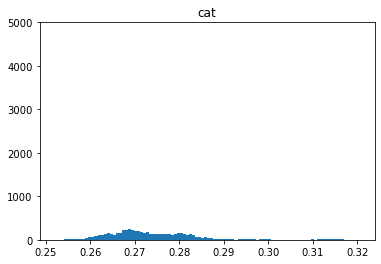

In [55]:
import matplotlib.pyplot as plt

plt.hist(sample_submission['Best Performance'],bins=100)
plt.ylim((0,5000))
plt.title('cat')
plt.show()

In [56]:
oof = pd.DataFrame({'id':X.index, 'catboost_oof': oof})
oof.to_csv("oof.csv", index=False)

In [57]:
print("Average cv roc auc score %0.3f ± %0.3f" % (np.mean(roc_auc), np.std(roc_auc)))
print("Average cv roc average precision %0.3f ± %0.3f" % (np.mean(average_precision), np.std(average_precision)))

print("Roc auc score OOF %0.3f" % roc_auc_score(y_true=y, y_score=oof.catboost_oof))
print("Average precision OOF %0.3f" % average_precision_score(y_true=y, y_score=oof.catboost_oof))

Average cv roc auc score 0.621 ± 0.067
Average cv roc average precision 0.250 ± 0.066
Roc auc score OOF 0.525
Average precision OOF 0.154


<AxesSubplot:xlabel='Importance', ylabel='Features'>

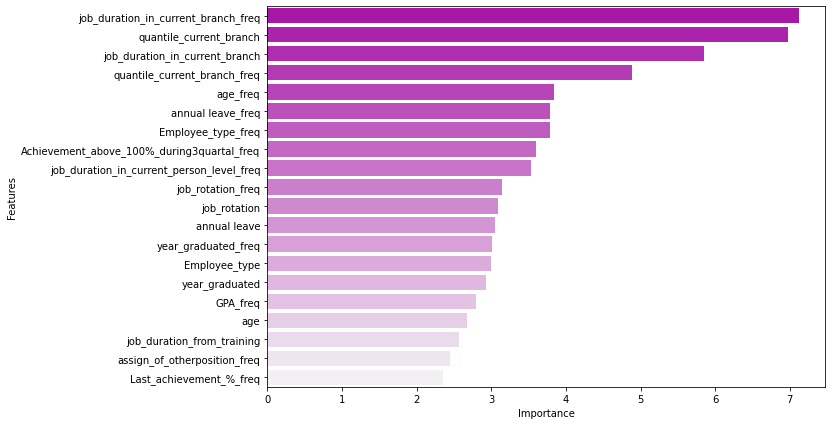

In [58]:
feature_dict = {'Features': catb.feature_names_, 'Importance': catb.feature_importances_}
feature_imp = pd.DataFrame(feature_dict).sort_values(by=['Importance'], ascending=False)

plt.figure(figsize=(10,7))
df_imp = feature_imp.head(20)
sns.barplot(y=df_imp['Features'], x=df_imp['Importance'], palette='light:m_r')

In [59]:
#catb.save_model('model_one')